In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
df = pd.read_csv("wholesale_customers_data.csv")

In [3]:
df.head()

channel        region  fresh  milk  grocery  frozen  detergents_paper   
0  retail  Other Region  12669  9656     7561     214              2674  \
1  retail  Other Region   7057  9810     9568    1762              3293   
2  retail  Other Region   6353  8808     7684    2405              3516   
3  horeca  Other Region  13265  1196     4221    6404               507   
4  retail  Other Region  22615  5410     7198    3915              1777   

   delicassen  
0        1338  
1        1776  
2        7844  
3        1788  
4        5185

In [4]:
prod_cols = ["fresh", "milk", "grocery", "frozen", "detergents_paper", "delicassen"]

In [5]:
df_original = df.copy()

In [6]:
scaler = StandardScaler()
scaler.fit(df.loc[:, prod_cols])
X_scaled = scaler.transform(df.loc[:, prod_cols])

In [7]:
df = pd.DataFrame(X_scaled, columns=prod_cols)
df.head()

fresh      milk   grocery    frozen  detergents_paper  delicassen
0  0.052933  0.523568 -0.041115 -0.589367         -0.043569   -0.066339
1 -0.391302  0.544458  0.170318 -0.270136          0.086407    0.089151
2 -0.447029  0.408538 -0.028157 -0.137536          0.133232    2.243293
3  0.100111 -0.624020 -0.392977  0.687144         -0.498588    0.093411
4  0.840239 -0.052396 -0.079356  0.173859         -0.231918    1.299347

In [8]:
df = df_original.merge(df, left_index=True, right_index=True, how="left")
df.head()

channel        region  fresh_x  milk_x  grocery_x  frozen_x   
0  retail  Other Region    12669    9656       7561       214  \
1  retail  Other Region     7057    9810       9568      1762   
2  retail  Other Region     6353    8808       7684      2405   
3  horeca  Other Region    13265    1196       4221      6404   
4  retail  Other Region    22615    5410       7198      3915   

   detergents_paper_x  delicassen_x   fresh_y    milk_y  grocery_y  frozen_y   
0                2674          1338  0.052933  0.523568  -0.041115 -0.589367  \
1                3293          1776 -0.391302  0.544458   0.170318 -0.270136   
2                3516          7844 -0.447029  0.408538  -0.028157 -0.137536   
3                 507          1788  0.100111 -0.624020  -0.392977  0.687144   
4                1777          5185  0.840239 -0.052396  -0.079356  0.173859   

   detergents_paper_y  delicassen_y  
0           -0.043569     -0.066339  
1            0.086407      0.089151  
2            0.133232      2.243293  
3           -0.498588      0.093411  
4           -0.231918      1.299347

In [9]:
prod_cols = [col for col in df.columns if "_y" in col]

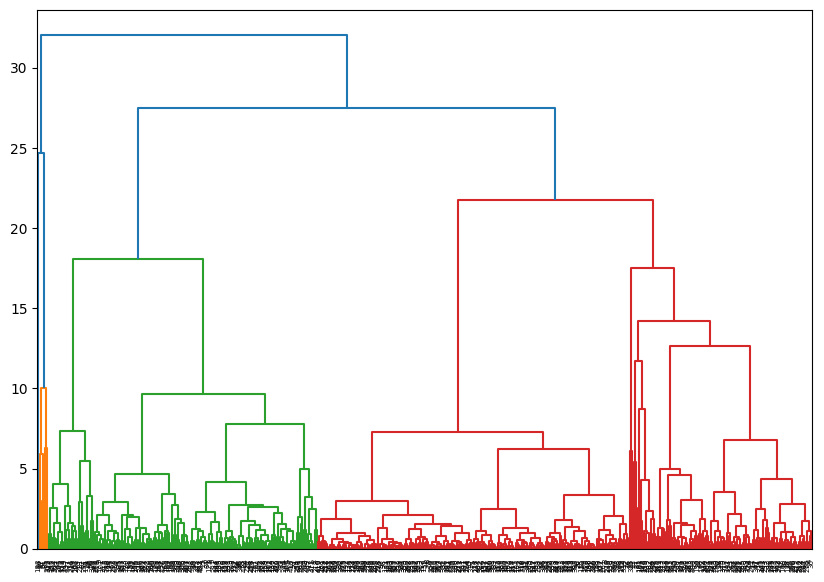

In [10]:
plt.figure(figsize=(10, 7))
mergings = shc.linkage(df.loc[:, prod_cols], method='ward')
dend = shc.dendrogram(mergings)

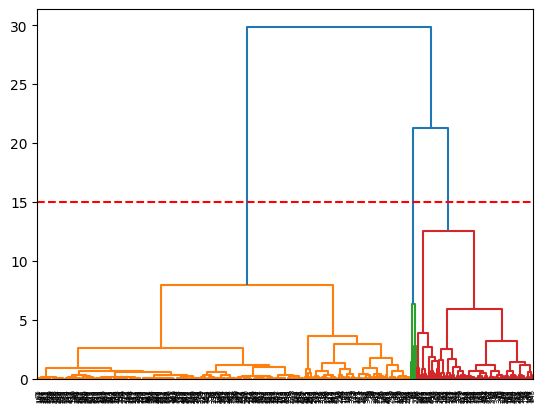

In [11]:
mergings_2 = shc.linkage(df.loc[:, ["grocery_y", "detergents_paper_y"]], method="ward")
dend_2 = shc.dendrogram(mergings_2)
plt.axhline(15, color="red", ls="--")

In [12]:
df["cluster"] = shc.fcluster(mergings_2, 15, criterion="distance")

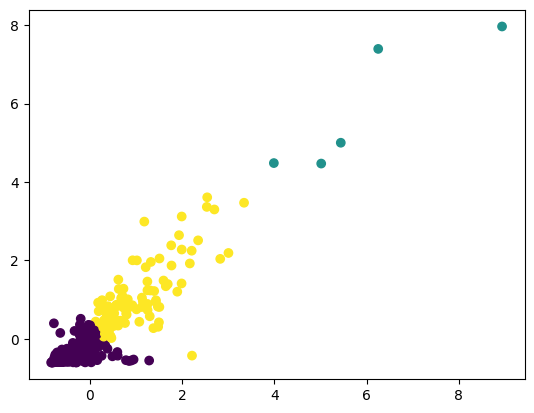

In [13]:
plt.scatter(df["grocery_y"], df["detergents_paper_y"], c=df["cluster"])

In [14]:
df["cluster"] = shc.fcluster(mergings, 25, criterion="distance")

In [15]:
df["cluster"].value_counts()

cluster
3    281
2    153
1      6
Name: count, dtype: int64

In [20]:
df.groupby("cluster").mean()

TypeError: Could not convert retailretailretailretailhorecaretail to numeric

<Axes: xlabel='channel'>

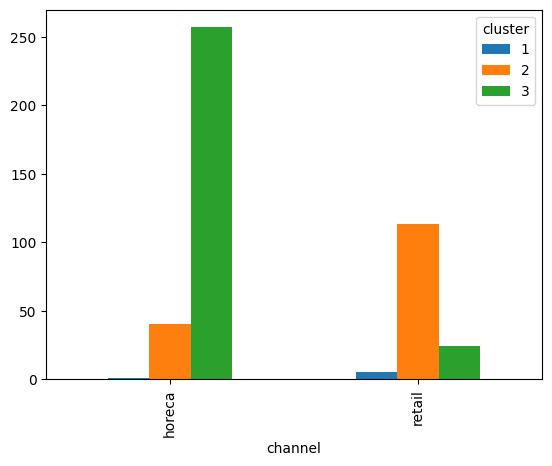

In [23]:
df.groupby(["channel", "cluster"]).size().unstack().plot.bar()

<Axes: xlabel='channel'>

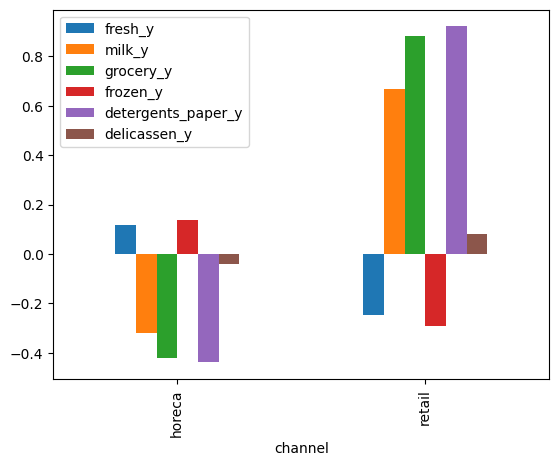

In [24]:
df.groupby("channel")[prod_cols].mean().plot.bar()

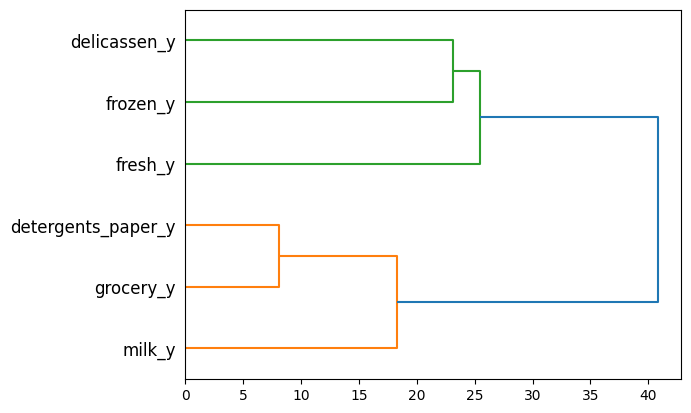

In [29]:
products = df.loc[:, prod_cols].T
mergings = shc.linkage(products, method="ward")
dend = shc.dendrogram(mergings, labels=prod_cols, orientation="right")

# DBScan

In [30]:
prod_cols = ["grocery_y", "detergents_paper_y"]

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

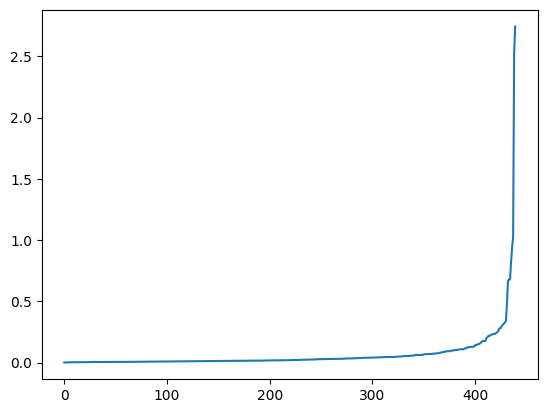

In [34]:
knn = NearestNeighbors(n_neighbors=2)
nbrs = knn.fit(df.loc[:, prod_cols])
distances, indices = nbrs.kneighbors(df.loc[:, prod_cols])
distances = np.sort(distances[:, 1])
plt.plot(distances)

In [35]:
dbscan = DBSCAN(eps=0.3, metric="euclidean")
df["dbscan_cluster"] = dbscan.fit_predict(df.loc[:, prod_cols])

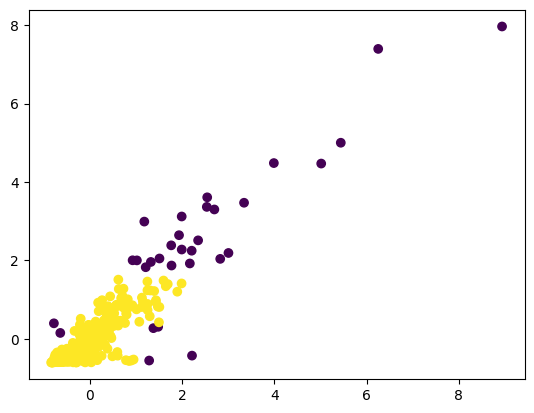

In [36]:
plt.scatter(df["grocery_y"], df["detergents_paper_y"], c=df["dbscan_cluster"])